Transfer learning of labels from annotated Reyfman object (GSE122960 - integration run on data processed with reference genome build 84) onto newly reprocessed Reyfman object (b93 + SARS, CellRanger version 7.0.0 exon-only).


In [1]:
import pathlib
import anndata
import scvi
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import sklearn.neighbors
import pynndescent
import numba
import warnings

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
torch.cuda.current_device()

0

### Load reference object - annotated Reyfman processed with older reference genome

In [6]:
reference = sc.read_h5ad('/projects/b1038/Pulmonary/sfenske/projects/sc_PF_2018/data/v2_final_object/v2_final_object.h5ad')

In [7]:
reference.obs['barcode'] = reference.obs['sample'].astype(str) + '_' + reference.obs.index

In [8]:
reference.obs['barcode'] = reference.obs['barcode'].str.replace(r'-1-\d+$', '', regex=True)

In [9]:
scanvae = scvi.model.SCANVI.load('models/reyfman_scanvi.model', reference)

INFO     File models/reyfman_scanvi.model/model.pt already downloaded                                              


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [10]:
scanvae.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'ann_level_3',
│   'unlabeled_category': 'Unknown',
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  17   │
│         n_cells          │ 77172 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  35   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │     0      │          0          │
│                    │     1      │          1          │
│                    │     2      │          2          │
│                    │     3      │          3          │
│                    │     4      │          4          │
│                    │     5      │          5          │
│                    │     6      │          6          │
│                    │     7      │          7          │
│                    │     8      │          8          │
│                    │     9      │          9          │
│                    │     10     │         10          │
│                    │     11     │         11          │
│                    │     12     │         12          │
│                    │     13     │         13          │
│                    │     14     │         14          │
│                    │     15     │         15          │
│                    │     16     │         16          │
└────────────────────┴────────────┴─────────────────────┘

                                   labels State Registry                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃               Categories               ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['ann_level_3'] │                  AT1                   │          0          │
│                          │                 AT2-1                  │          1          │
│                          │                 AT2-2                  │          2          │
│                          │   Alveolar proliferating macrophages   │          3          │
│                          │                B cells                 │          4          │
│                          │              Basal cells               │          5          │
│                          │              CD4 T cells               │          6          │
│                          │              CD8 T cells               │          7          │
│                          │             Ciliated cells             │          8          │
│                          │          Classical monocytes           │          9          │
│                          │                  DC1                   │         10          │
│                          │                  DC2                   │         11          │
│                          │           Endothelial cells            │         12          │
│                          │              Fibroblasts               │         13          │
│                          │ Interstitial proliferating macrophages │         14          │
│                          │               Lymphatics               │         15          │
│                          │               Mast cells               │         16          │
│                          │              Migratory DC              │         17          │
│                          │                 MoAM-1                 │         18          │
│                          │                 MoAM-2                 │         19          │
│                          │             NK + gDT cells             │         20          │
│                          │        Non-classical monocytes         │         21          │
│                          │   Pericytes and smooth muscle cells    │         22          │
│                          │           Perivascular MoAM            │         23          │
│                          │              Plasma cells              │         24          │
│                          │         Proliferating T cells          │         25          │
│                          │     Proliferating epithelial cells     │         26          │
│                          │            Secretory cells             │         27          │
│                          │                 TRAM-1                 │         28          │
│                          │                 TRAM-2                 │         29          │
│                          │                 TRAM-3                 │         30          │
│                          │         Transitional Club-AT2          │         31          │
│                          │                 Tregs                  │         32          │
│                          │                  pDC                   │         33          │
│                          │                Unknown                 │         34          │
└──────────────────────────┴────────────────────────────────────────┴─────────────────────┘

### Load object processed with newer reference genome version

In [11]:
base_path = pathlib.Path('../../data/21scArches/reyfman')

In [12]:
datasets = []
samples = [folder for folder in base_path.iterdir() if folder.is_dir()]
for sample in samples:
    sample_name = str(sample).split('/')[-1]
    ds = sc.read_10x_h5(f'{sample}/filtered_feature_bc_matrix.h5')
    ds.obs["Library ID"] = sample_name
    ds.layers["counts"] = ds.X.copy()
    ds.var_names_make_unique()
    datasets.append(ds)
reyfman_reproc = sc.concat(datasets, join='outer', label='batch', index_unique='-')

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.w

### Rename gene names

In [14]:
reyfman_reproc.var.index = [i.split('_')[1] for i in reyfman_reproc.var.index]

### Remove low quality cells - subset on cells in both objects

Create unique barcodes that will map between dataframes.

In [15]:
data = """
SC07    Donor_01
SC08    IPF_01
SC09    IPF_02
SC10    Donor_02
SC13    Cryobiopsy_01
SC18    Donor_03
SC19    IPF_03
SC20    Donor_04
SC21    IPF_04
SC22    Donor_05
SC23    HP_01
SC24    Donor_06
SC25    SSc-ILD_01
SC27    Donor_07
SC28    Myositis-ILD_01
SC29    Donor_08
SC30    SSc-ILD_02
"""

# Create a dictionary mapping "library_id" to "sample"
library_to_sample = {line.split()[0]: line.split()[1] for line in data.strip().split('\n')}

In [16]:
reyfman_reproc.obs['sample'] = reyfman_reproc.obs['Library ID'].map(library_to_sample)
reyfman_reproc.obs['barcode'] = reyfman_reproc.obs['sample'].astype(str) + '_' + reyfman_reproc.obs.index
reyfman_reproc.obs['barcode'] = reyfman_reproc.obs['barcode'].str.replace(r'-1-\d+$', '', regex=True)

In [17]:
reyfman_reproc.obs

,Library ID,batch,sample,barcode
AAACCTGAGCCGGTAA-1-0,SC24,0,Donor_06,Donor_06_AAACCTGAGCCGGTAA
AAACCTGAGCGATTCT-1-0,SC24,0,Donor_06,Donor_06_AAACCTGAGCGATTCT
AAACCTGAGCTGCCCA-1-0,SC24,0,Donor_06,Donor_06_AAACCTGAGCTGCCCA
AAACCTGAGGAGCGTT-1-0,SC24,0,Donor_06,Donor_06_AAACCTGAGGAGCGTT
AAACCTGAGGCGATAC-1-0,SC24,0,Donor_06,Donor_06_AAACCTGAGGCGATAC
...,...,...,...,...
TTTGTCACATTGGGCC-1-16,SC23,16,HP_01,HP_01_TTTGTCACATTGGGCC
TTTGTCAGTACCGAGA-1-16,SC23,16,HP_01,HP_01_TTTGTCAGTACCGAGA
TTTGTCAGTGACGGTA-1-16,SC23,16,HP_01,HP_01_TTTGTCAGTGACGGTA
TTTGTCAGTTGCCTCT-1-16,SC23,16,HP_01,HP_01_TTTGTCAGTTGCCTCT


In [18]:
reyfman_reproc = reyfman_reproc[reyfman_reproc.obs['barcode'].isin(reference.obs['barcode'])]

### Filter for lowly expressed genes & cell

In [19]:
sc.pp.filter_genes(reyfman_reproc, min_counts=3)

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [20]:
sc.pp.filter_cells(reyfman_reproc, min_counts=200)

### Calculate QC metrics

In [21]:
reyfman_reproc.var["mito"] = ["MT-" in i for i in reyfman_reproc.var_names]
sc.pp.calculate_qc_metrics(reyfman_reproc, qc_vars=["mito"], inplace=True)

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


### Save raw object

In [22]:
reyfman_reproc.write_h5ad('../../data/21scArches/reyfman/reyfman_reprocessed_raw_unnormalized.h5ad')

### Normalize the data using log normalization

In [23]:
sc.pp.normalize_total(reyfman_reproc, target_sum=1e4)
sc.pp.log1p(reyfman_reproc)
reyfman_reproc.raw = reyfman_reproc # freeze the state in `.raw`

In [24]:
reyfman_reproc.raw.shape

(76188, 28064)

### Save raw object

In [25]:
reyfman_reproc.write_h5ad('../../data/21scArches/reyfman/reyfman_reprocessed_raw.h5ad')

### Feature Selection
Select 2000 HVGs using library as the batch key (2000 because this is number of HVGs in reference object).

In [26]:
sc.pp.highly_variable_genes(
    reyfman_reproc,
    n_top_genes=2000,
    subset=True,
    batch_key="Library ID"
)

In [27]:
reyfman_reproc

AnnData object with n_obs × n_vars = 76188 × 2000
    obs: 'Library ID', 'batch', 'sample', 'barcode', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [28]:
scanvae.prepare_query_anndata(reyfman_reproc, scanvae)

INFO     Found 88.75% reference vars in query data.                                                                


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [29]:
(reyfman_reproc.var_names != reference.var_names).sum()

0

Identical HVGs between two objects.

### Setup and train model

In [30]:
reyfman_reproc.obs["pred_labels"] = scanvae.unlabeled_category_

In [31]:
reyfman_reproc.obs['batch'] = (
    reyfman_reproc.obs['Library ID'].cat.codes 
    + reference.obs.batch.astype(int).max() 
    + 10
).astype(str).astype('category')

In [32]:
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [33]:
model = scvi.model.SCANVI.load_query_data(reyfman_reproc, scanvae, accelerator='gpu')

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/data/_manager.py:216: UserWarning: Missing labels key ann_level_3. Filling in with unlabeled category Unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(


In [34]:
model.train(max_epochs=500, **train_kwargs_surgery)
model.save('models/reyfman_on_reyfman_diff_ref_genomes.model')

INFO     Training for 500 epochs.                                                                                  


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To proper

Epoch 53/500:  11%|██████████▍                                                                                       | 53/500 [12:29<1:45:18, 14.14s/it, v_num=1, train_loss_step=494, train_loss_epoch=465]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 490.586. Signaling Trainer to stop.


In [35]:
model = scanvae.load('models/reyfman_on_reyfman_diff_ref_genomes.model', reyfman_reproc)

INFO     File models/reyfman_on_reyfman_diff_ref_genomes.model/model.pt already downloaded                         


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...


### Get latent representation of model

In [36]:
reyfman_reproc.obsm['X_scvi'] = model.get_latent_representation()

In [37]:
sc.pp.neighbors(reyfman_reproc, use_rep='X_scvi')
sc.tl.umap(reyfman_reproc, min_dist=0.3)

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/b1

In [38]:
sc.tl.leiden(reyfman_reproc)

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


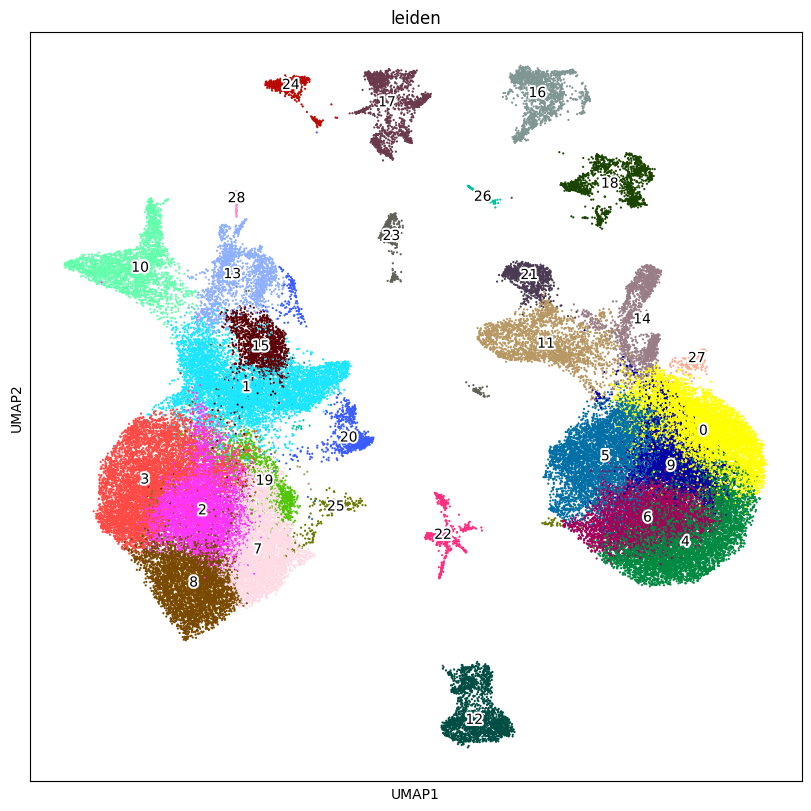

In [39]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
sc.pl.umap(
    reyfman_reproc, 
    color='leiden', 
    legend_loc='on data', 
    ax=ax, 
    legend_fontweight='normal',
    legend_fontoutline=3,
    size=10
)

<Axes: title={'center': 'total_counts'}, xlabel='UMAP1', ylabel='UMAP2'>

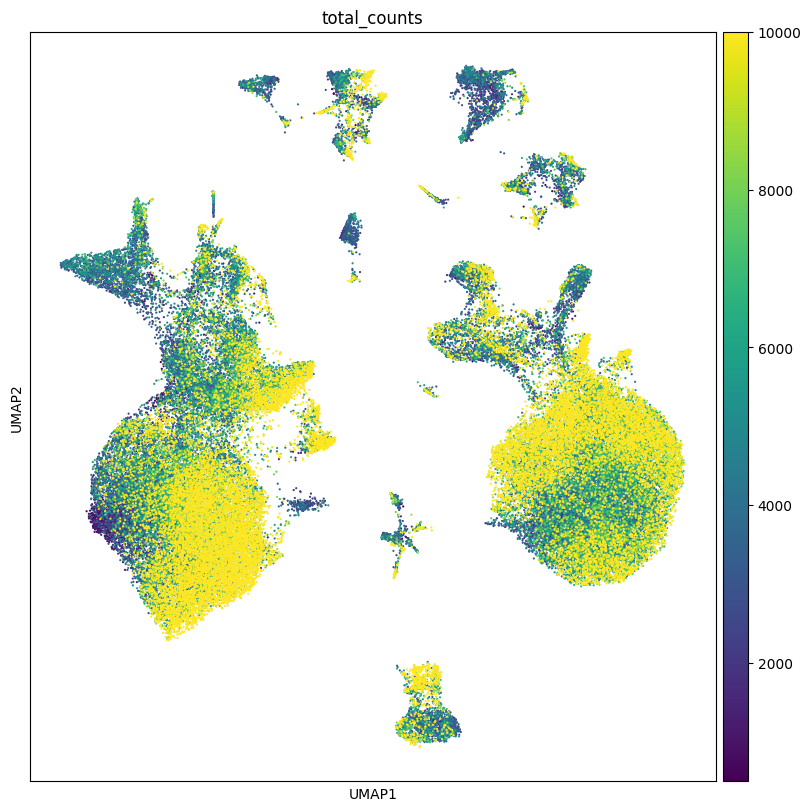

In [40]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
sc.pl.umap(
    reyfman_reproc,
    color='total_counts',
    legend_loc='on data',
    legend_fontweight='normal',
    legend_fontoutline=3,
    show=False,
    size=10,
    ax=ax,
    vmax=10000
)

### Get raw object
Raw counts are not preserved. Grab them again.

In [41]:
reyfman_reproc_raw = sc.read_h5ad('../../data/21scArches/reyfman/reyfman_reprocessed_raw.h5ad')

In [42]:
reyfman_reproc.raw = reyfman_reproc_raw

Code below is from https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/query_hlca_knn.html

In [43]:
reference_nn_index = pynndescent.NNDescent(reference.obsm['X_scVI'])

In [44]:
reference_nn_index.prepare()

In [45]:
ref_neighbors, ref_distances = reference_nn_index.query(reyfman_reproc.obsm['X_scvi'])

In [46]:
# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)

In [47]:
@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

In [48]:
ref_cats = reference.obs.ann_level_3.cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(reference.obs.ann_level_3.cat.categories)[p]
reyfman_reproc.obs["cell_type_pred"], reyfman_reproc.obs["cell_type_uncertainty"] = p, u

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


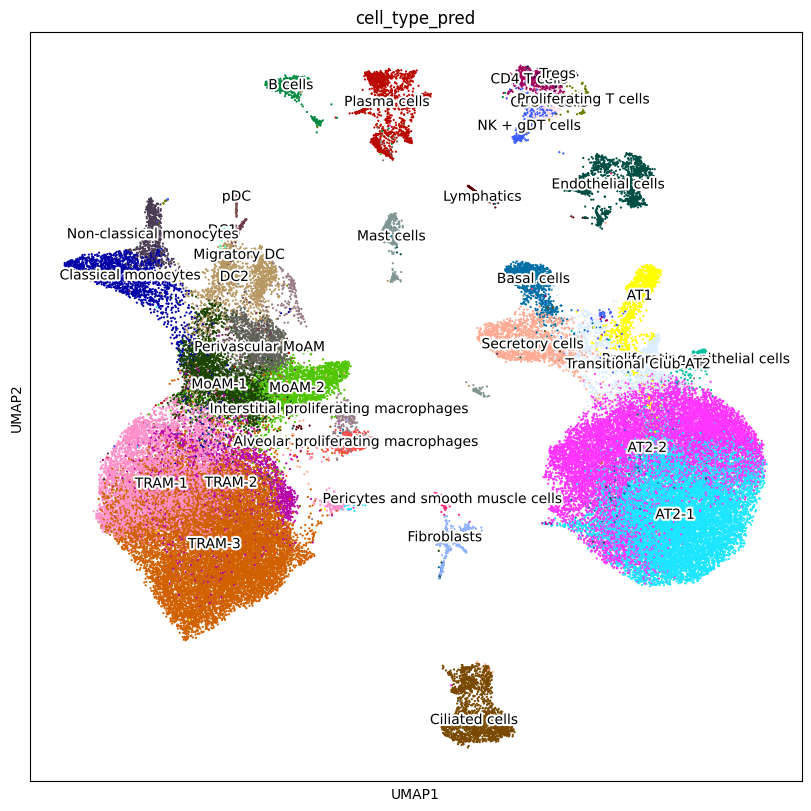

In [49]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
sc.pl.umap(
    reyfman_reproc, 
    color='cell_type_pred', 
    legend_loc='on data', 
    ax=ax, 
    legend_fontweight='normal',
    legend_fontoutline=3,
    size=10
)

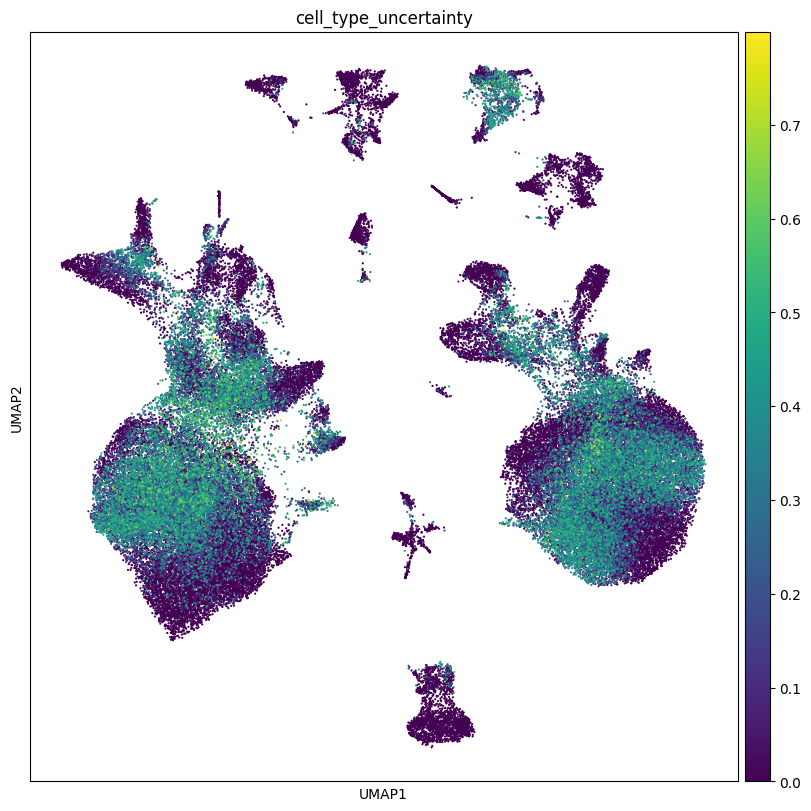

In [50]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
sc.pl.umap(
    reyfman_reproc, 
    color='cell_type_uncertainty', 
    legend_loc='on data', 
    ax=ax, 
    legend_fontweight='normal',
    legend_fontoutline=3,
    size=10
)

### Get markers

In [51]:
def get_markers(
    adata,
    groupby,
    key="rank_genes_groups",
    p_val_cutoff=0.05,
    logfc_cutoff=0.5
):
    """\
    Extract markers from adata into Seurat-like table

    Extracts markers after they are computed by ``scanpy``. Produces Seurat-like
    table with fields
    ``"p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"``

    Calculates the percentage of cells that express a given gene
    in the target cluster (``pct.1`` field) and outside the cluster
    (``pct.2`` field) from ``adata.raw`` matrix.

    Parameters
    ----------
    adata
        Annotated data matrix.
    groupby
        ``adata.obs`` field used for marker calculation
    key
        ``adata.uns`` key that has computed markers
    p_val_cutoff
        Drop all genes with adjusted p-value greater than or equal to this
    logfc_cutoff
        Drop all genes with average logFC less than or equal to this

    Returns
    -------
    Returns a pandas dataframe with above listed columns, optionally
    subsetted on the genes that pass the cutoffs.
    ``p_val`` field is a copy of adjusted p-value field.

    Example
    -------
    >>> sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon", n_genes=200)
    >>> markers = sc_utils.get_markers(adata, "leiden")
    >>> markers.to_csv("markers.csv")
    """
    markers = pd.concat([
        pd.DataFrame(adata.uns[key]["names"]).melt(),
        pd.DataFrame(adata.uns[key]["pvals_adj"]).melt(),
        pd.DataFrame(adata.uns[key]["logfoldchanges"]).melt()
    ], axis=1)
    markers.columns = ("cluster", "gene", "cluster2", "p_val_adj", "cluster3", "avg_logFC")
    markers = markers.loc[:, ["cluster", "gene", "avg_logFC", "p_val_adj"]]
    markers = markers.loc[markers.avg_logFC > logfc_cutoff, ]
    markers = markers.loc[markers.p_val_adj < p_val_cutoff, ]
    markers["pct.1"] = pd.Series(dtype=float)
    markers["pct.2"] = pd.Series(dtype=float)

    for cluster in markers.cluster.unique():
        cells = adata.obs[groupby] == cluster
        in_cluster_selector = markers.cluster == cluster
        genes = markers.gene[in_cluster_selector]
        in_cluster = np.sum(adata.raw[cells, genes].X > 0, axis=0).A1 / cells.sum()
        markers.loc[in_cluster_selector, "pct.1"] = in_cluster
        other_cells = adata.obs[groupby] != cluster
        other_clusters = np.sum(adata.raw[other_cells, genes].X > 0, axis=0).A1 / other_cells.sum()
        markers.loc[in_cluster_selector, "pct.2"] = other_clusters

    markers["p_val"] = markers.p_val_adj
    markers = markers.loc[:, ["p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"]]
    return markers

### Get markers for predictions

In [52]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    sc.tl.rank_genes_groups(reyfman_reproc, "cell_type_pred", method="t-test", n_genes=200)

In [53]:
markers = get_markers(reyfman_reproc, "cell_type_pred")

In [54]:
markers.sort_values(["cluster", "avg_logFC"], ascending=[True, False], inplace=True)

In [55]:
markers.groupby("cluster").head(2)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
166,5.954072e-107,6.939611,0.370309,0.007988,5.954072e-107,AT1,MYRF
79,1.230100e-155,6.852523,0.525438,0.019670,1.230100e-155,AT1,RTKN2
203,0.000000e+00,5.463263,0.998397,0.824065,0.000000e+00,AT2-1,SFTPC
202,0.000000e+00,4.786208,0.994149,0.624209,0.000000e+00,AT2-1,SFTPA1
403,0.000000e+00,5.349092,0.999221,0.822893,0.000000e+00,AT2-2,SFTPC
...,...,...,...,...,...,...,...
6277,4.279750e-184,3.850047,0.560188,0.062657,4.279750e-184,Transitional Club-AT2,CTSE
6499,2.030365e-17,9.590465,0.364641,0.001026,2.030365e-17,Tregs,FOXP3
6493,5.588824e-19,8.726595,0.414365,0.002263,5.588824e-19,Tregs,CTLA4
6719,6.408102e-09,11.836311,0.333333,0.000197,6.408102e-09,pDC,CLEC4C


### Save
Fill in NA values in var with 0s and False

I assume that NA values stem from differences in genes between reference genomes.

In [56]:
bool_columns = ['highly_variable', 'highly_variable_intersection', 'mito']
reyfman_reproc.var[bool_columns] = reyfman_reproc.var[bool_columns].fillna(False)

# Fill NaN values with 0 for the rest of the columns
reyfman_reproc.var.fillna(0, inplace=True)

In [60]:
reyfman_reproc.write_h5ad('../../data/21scArches/reyfman_reprocessed/reyfman_reprocessed.h5ad')

In [61]:
markers.to_csv('../../data/21scArches/reyfman_reprocessed/reyfman_reprocessed-markers.csv')

In [62]:
reyfman_reproc.obs.to_csv('../../data/21scArches/reyfman_reprocessed/reyfman_reprocessed-metadata.csv')